1. 지역 클러스터링 수행할 때 매물_HC만 포함해서 실루엣 계수 확인하기

2. 매물 클러스터링할 때 보면 실루엣 계수로 확인한 적절 k값대로 클러스터링 안된 경우 있다 확인해서 수정(11개-> 10개)

# EDA

In [1]:
import pandas as pd
import random
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint, uniform
from sklearn.utils.class_weight import compute_class_weight

In [2]:
pd.set_option('display.max_columns', 30)

In [3]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    
seed_everything(37)

In [10]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'AppleGothic'

elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rcParams["font.family"] = font_name
elif platform.system() == 'Linux':
    plt.rcParams['font.family'] = 'NanumGothic'


plt.rcParams['axes.unicode_minus'] = False

In [11]:
train = pd.read_csv('./data/train.csv')

# Data Preprocessing

## 전용면적, 월세, 보증금 결측 샘플 제거

부동산 허위매물을 판별하는데에 가장 중요한 전용면적, 월세, 보증금 3가지는 허위매물을 판단하는데에 핵심적인 요소이므로 없어서는 안되지만 결측치 처리를 하기에는 허위매물과 실매물의 특성이 희석될 수 있을 것이라 판단해 결측 샘플을 제거해야 한다고 생각했습니다.

In [12]:
train = pd.read_csv('./data/train.csv')

In [13]:
ttrain3 = train.copy()

In [14]:
ttrain3.isnull().sum()

ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      787
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64

전용면적 결측값이 787개나 있다.

In [15]:
ttrain3 = ttrain3.dropna(subset = ['전용면적', '월세', '보증금'], how = 'any')

## 나머지 결측치 처리

In [16]:
ttrain3.isnull().sum()

ID          0
매물확인방식      0
보증금         0
월세          0
전용면적        0
해당층       156
총층          0
방향          0
방수          0
욕실수         1
주차가능여부      0
총주차대수     264
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64

중앙값 보간

In [17]:
# 숫자형 컬럼만 선택
numeric_cols = ttrain3.select_dtypes(include=['number']).columns
ttrain3[numeric_cols].median()

보증금       135000000.0
월세           370000.0
전용면적             26.4
해당층               4.0
총층                8.0
방수                1.0
욕실수               1.0
총주차대수            17.0
관리비               5.0
허위매물여부            0.0
dtype: float64

In [18]:
ttrain3[numeric_cols] = ttrain3[numeric_cols].fillna(ttrain3[numeric_cols].median())

현재 해당층 156개와 욕실수 1개, 총주차대수 264개의 값이 각 컬럼의 중앙값으로 처리되었습니다.

In [16]:
ttrain3.shape

(1665, 17)

## 지역적 특성을 담는 컬럼 만들기 Feature Transformation

데이터의 컬럼들 중, 전용면적, 총층, 방수, 욕실수, 총주차대수, 관리비를 이용해 비슷한 매물끼리 클러스터링합니다.
지역에 따라 가격 차이를 보인다는 가정 하에 클러스터링을 진행하기 때문에 월세와 보증금은 클러스터링을 위한 데이터에 포함하지 않았습니다.
관리비의 경우, 간접적으로 매물의 특성을 반영한다고 생각해 포함합니다.

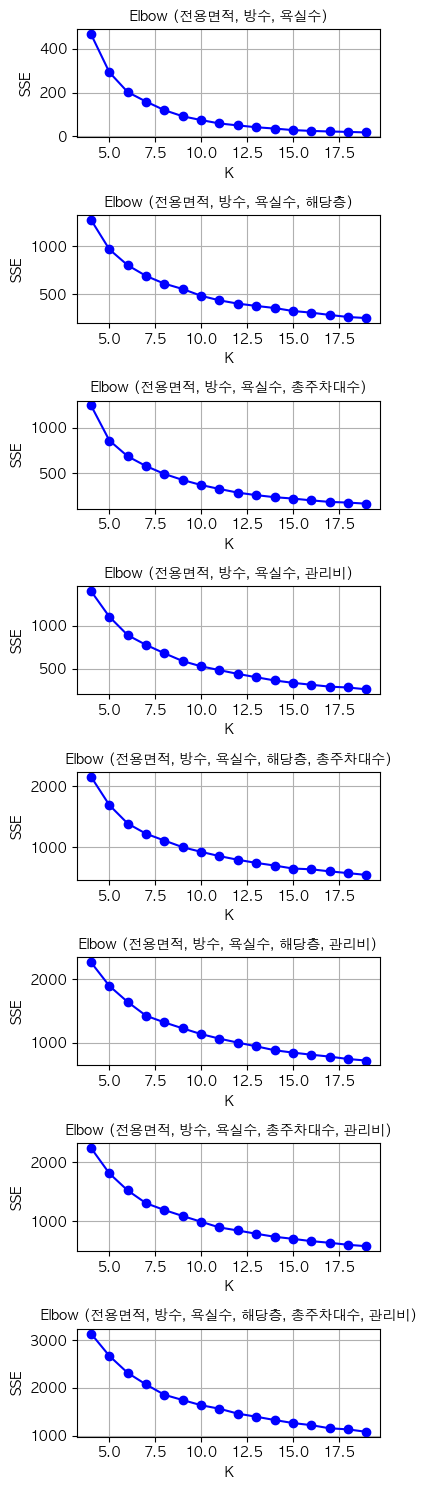

In [29]:
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 사용할 컬럼 선택
columns = ['전용면적', '방수', '욕실수', '해당층', '총주차대수', '관리비']

def powerset_with_required(required, optional):
    """필수 컬럼을 포함한 모든 부분집합 생성"""
    subsets = []
    
    # 나머지 선택 컬럼의 모든 부분집합 생성
    for r in range(len(optional) + 1):  # 0개부터 len(optional)개까지 선택
        for combination in itertools.combinations(optional, r):
            subsets.append(tuple(required) + combination)  # 필수 컬럼 + 선택 조합

    return subsets

# 필수 컬럼
required_columns = ['전용면적', '방수', '욕실수']
# 선택 가능 컬럼
optional_columns = ['해당층', '총주차대수', '관리비']

# 필수 컬럼을 포함한 멱집합 생성
all_subsets = powerset_with_required(required_columns, optional_columns)

# 3x3 subplot 생성
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(4, 15))

scaler = StandardScaler()

for ax, subset in zip(axes.flat, all_subsets):
    subset = list(subset)
    X_m = ttrain3[subset].dropna().sample(n=1000, random_state=42)  # 1000개 샘플 사용

    # 데이터 스케일링
    X_m_scaled = scaler.fit_transform(X_m)

    # 최적의 K값 찾기 (Elbow Method)
    sse = []
    for k in range(4, 20):  # K 범위를 줄여 속도 개선
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_m_scaled)
        sse.append(kmeans.inertia_)

    # Elbow Plot 그리기
    ax.plot(range(4, 20), sse, marker='o', linestyle='-', color='b')
    ax.set_xlabel('K')
    ax.set_ylabel('SSE')
    ax.set_title(f'Elbow ({", ".join(subset)})', fontsize=10)
    ax.grid(True)

# 그래프 정렬
plt.tight_layout()
plt.show()


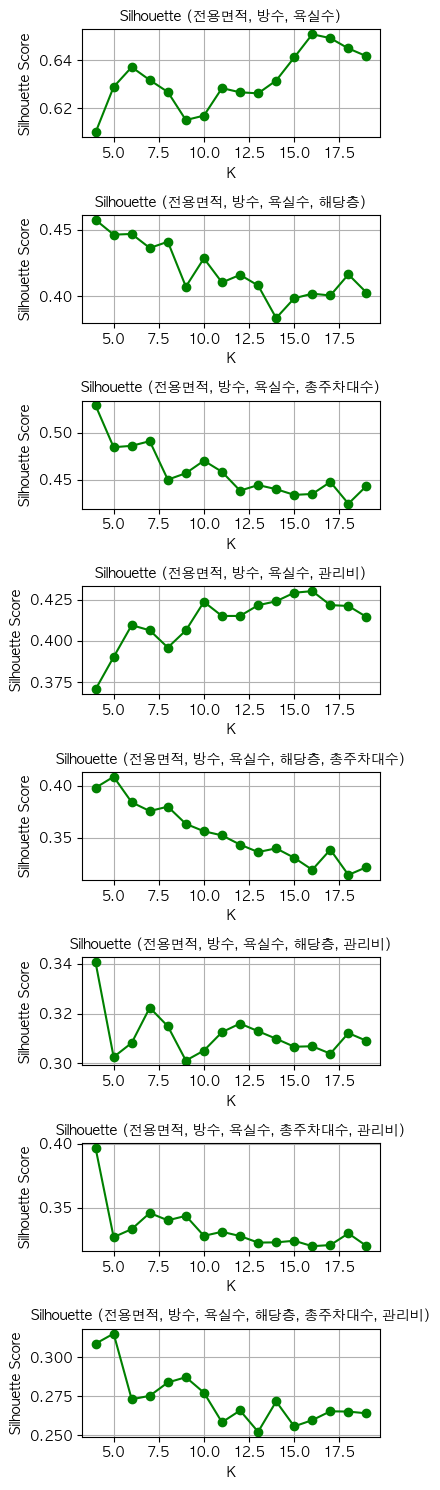

In [27]:
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples


# 사용할 컬럼 선택
columns = ['전용면적', '방수', '욕실수', '해당층', '총주차대수', '관리비']

def powerset_with_required(required, optional):
    """필수 컬럼을 포함한 모든 부분집합 생성"""
    subsets = []
    
    # 나머지 선택 컬럼의 모든 부분집합 생성
    for r in range(len(optional) + 1):  # 0개부터 len(optional)개까지 선택
        for combination in itertools.combinations(optional, r):
            subsets.append(tuple(required) + combination)  # 필수 컬럼 + 선택 조합

    return subsets

# 필수 컬럼
required_columns = ['전용면적', '방수', '욕실수']
# 선택 가능 컬럼
optional_columns = ['해당층', '총주차대수', '관리비']

# 필수 컬럼을 포함한 멱집합 생성
all_subsets = powerset_with_required(required_columns, optional_columns)

# 3x3 subplot 생성
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(4, 15))

scaler = StandardScaler()

for ax, subset in zip(axes.flat, all_subsets):
    subset = list(subset)
    X_m = ttrain3[subset].dropna().sample(n=1000, random_state=42)  # 1000개 샘플 사용

    # 데이터 스케일링
    X_m_scaled = scaler.fit_transform(X_m)

    # 최적의 K값 찾기 (Silhouette Score)
    silhouette_scores = []
    for k in range(4, 20):  # K 범위를 줄여 속도 개선
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_m_scaled)
        score = silhouette_score(X_m_scaled, labels)  # 실루엣 계수 계산
        silhouette_scores.append(score)

    # Silhouette Plot 그리기
    ax.plot(range(4, 20), silhouette_scores, marker='o', linestyle='-', color='g')
    ax.set_xlabel('K')
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Silhouette ({", ".join(subset)})', fontsize=10)
    ax.grid(True)

# 그래프 정렬
plt.tight_layout()
plt.show()


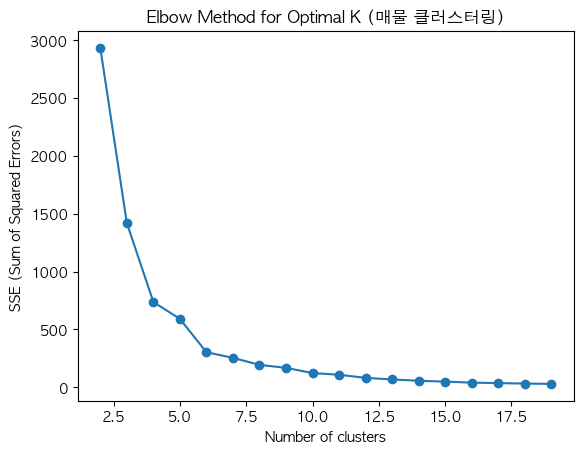

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_m = ttrain3[['전용면적', '방수', '욕실수']]

scaler = StandardScaler()
X_m_scaled = scaler.fit_transform(X_m)

# 최적의 K값 찾기 (Elbow Method)
sse = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_m_scaled)
    sse.append(kmeans.inertia_)

# Elbow Plot
plt.plot(range(2, 20), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K (매물 클러스터링)')
plt.show()


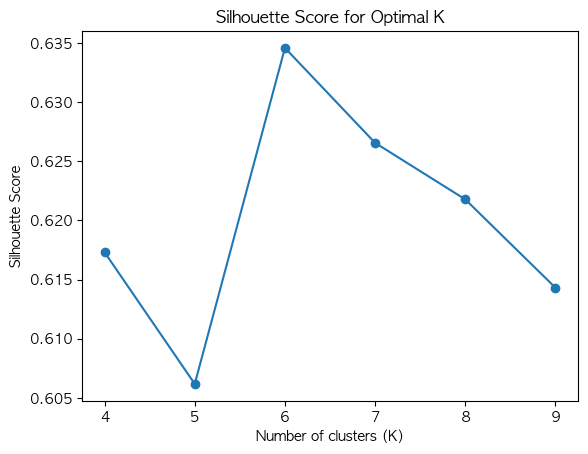

최적의 K값: 6, 최고 실루엣 계수: 0.6346


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 다양한 K값에 대해 실루엣 계수 계산
silhouette_scores = []
K_range = range(4, 10)  # K 값 범위

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_m_scaled)
    score = silhouette_score(X_m_scaled, labels)
    silhouette_scores.append(score)

# 실루엣 계수 시각화
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

# 최적의 K값 출력
best_k = K_range[np.argmax(silhouette_scores)]
print(f'최적의 K값: {best_k}, 최고 실루엣 계수: {max(silhouette_scores):.4f}')


In [21]:
X_m

,전용면적,방수,욕실수
3,36.30,2.0,1.0
5,29.50,2.0,1.0
8,31.55,2.0,2.0
9,39.66,2.0,1.0
10,23.69,1.0,1.0
...,...,...,...
2446,17.50,1.0,1.0
2447,48.95,2.0,1.0
2449,17.50,1.0,1.0
2450,22.87,2.0,1.0


### 계층적 클러스터링

/var/folders/rc/3jzqjhp56_v2qxb49fkb1x880000gn/T/ipykernel_14571/2374563125.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


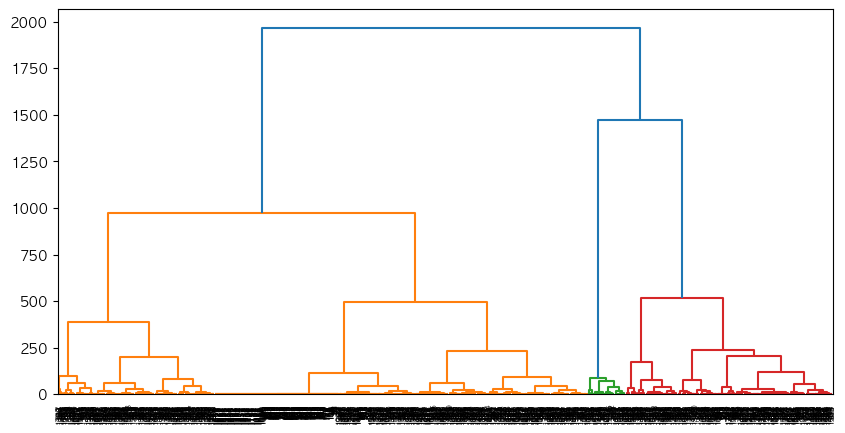

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import nan_euclidean_distances

X_m = ttrain3[['전용면적', '방수', '욕실수']]

scaler = StandardScaler()
X_m_scaled = scaler.fit_transform(X_m)

# NaN을 고려한 거리 행렬 생성
distance_matrix = nan_euclidean_distances(X_m_scaled)

# 계층적 클러스터링 수행
linkage_matrix = linkage(distance_matrix, method='ward')

# 덴드로그램 출력
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.show()

kmeans 알고리즘으로 알아본 최적의 k값은 6이기 때문에 계층적 군집화의 클러스터 개수 또한 6개로 진행합니다.

In [24]:
from scipy.cluster.hierarchy import fcluster

# 클러스터 개수를 6개로 설정하여 데이터 분류
labels = fcluster(linkage_matrix, t=6, criterion='maxclust')

print("클러스터 라벨:", labels, "/", len(labels))

클러스터 라벨: [6 6 4 ... 2 6 6] / 1665


In [25]:
# Hierarchical Clustering
property_hierarchical_clustering = pd.Series(labels)
property_hierarchical_clustering.index = ttrain3.index
property_hierarchical_clustering

3       6
5       6
8       4
9       5
10      3
       ..
2446    2
2447    5
2449    2
2450    6
2451    6
Length: 1665, dtype: int32

In [26]:
ttrain3["매물_HC"] = property_hierarchical_clustering

In [27]:
ttrain3["매물_HC"].value_counts()

매물_HC
2    430
3    373
1    337
6    333
5    112
4     80
Name: count, dtype: int64

In [28]:
ttrain3[ttrain3.매물_HC == 2]

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,매물_HC
21,TRAIN_0021,전화확인,375500000.0,350000,19.07,2.0,5.0,서향,1.0,1.0,불가능,17.0,8,a15xR3G4V0,A플랫폼,2024-07-28,0,2
26,TRAIN_0026,현장확인,361000000.0,350000,17.50,6.0,6.0,남서향,1.0,1.0,가능,8.0,8,K86UF7I0P3,C플랫폼,2024-11-18,0,2
28,TRAIN_0028,현장확인,354500000.0,750000,19.83,4.0,5.0,남향,1.0,1.0,불가능,17.0,0,Q42YF3Y0I2,A플랫폼,2025-01-02,0,2
40,TRAIN_0040,현장확인,361000000.0,440000,17.50,3.0,9.0,동향,1.0,1.0,가능,43.0,7,G52Iz8V2B9,C플랫폼,2023-11-26,0,2
41,TRAIN_0041,현장확인,324000000.0,660000,20.26,11.0,14.0,동향,1.0,1.0,가능,21.0,2,G52Iz8V2B9,A플랫폼,2024-12-24,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,TRAIN_2421,현장확인,146500000.0,130000,17.50,21.0,21.0,서향,1.0,1.0,가능,109.0,9,J07Zn4B0R7,C플랫폼,2025-02-10,0,2
2441,TRAIN_2441,현장확인,136500000.0,550000,19.80,3.0,6.0,남향,1.0,1.0,불가능,4.0,2,l84az9J6A2,C플랫폼,2024-05-13,1,2
2444,TRAIN_2444,현장확인,31000000.0,370000,17.50,2.0,7.0,남서향,1.0,1.0,가능,50.0,0,G52Iz8V2B9,A플랫폼,2024-08-27,0,2
2446,TRAIN_2446,전화확인,365500000.0,190000,17.50,4.0,14.0,남향,1.0,1.0,가능,104.0,10,G38pb6B9C7,C플랫폼,2024-12-10,0,2


### DBSCAN

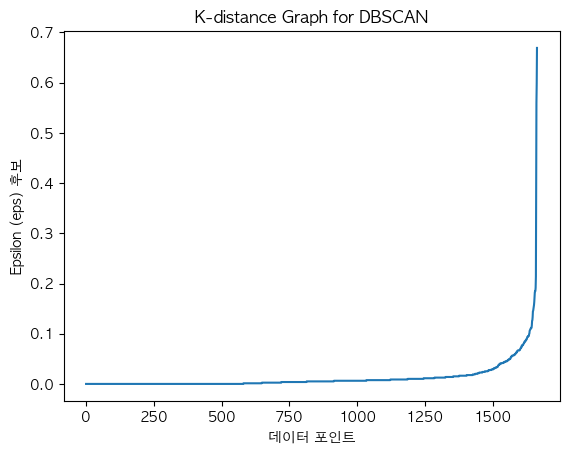

In [29]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 최근접 이웃 찾기 (4번째 이웃 거리 사용)
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_m_scaled)
distances, indices = neigh.kneighbors(X_m_scaled)

# K-거리 그래프 그리기
distances = np.sort(distances[:, 4], axis=0)  # 4번째 이웃 거리 정렬
plt.plot(distances)
plt.ylabel("Epsilon (eps) 후보")
plt.xlabel("데이터 포인트")
plt.title("K-distance Graph for DBSCAN")
plt.show()


일반적으로 그래프에서 급격한 변화가 시작되는 지점이 eps 최적값이다. 따라서 eps = 0.1로 설정

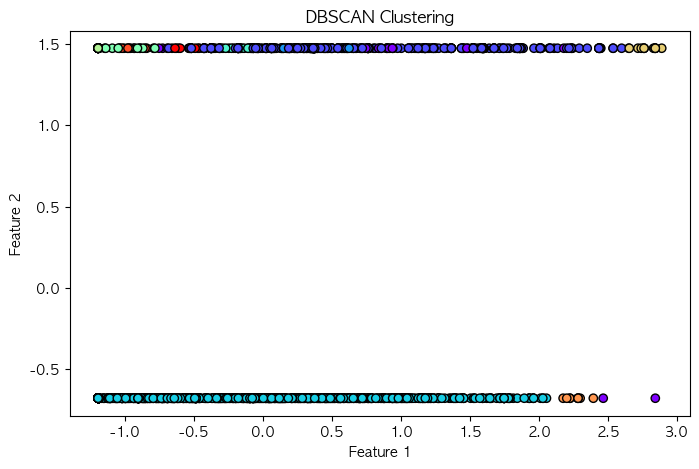

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# DBSCAN 적용
dbscan = DBSCAN(eps=0.1, min_samples=6) #eps : 두 데이터 포인트가 같은 클러스터에 속할 수 있는 최대 거리(밀집 기준)
y_dbscan = dbscan.fit_predict(X_m_scaled)

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 5))
plt.scatter(X_m_scaled[:, 0], X_m_scaled[:, 1], c=y_dbscan, cmap='rainbow', edgecolors='black')
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

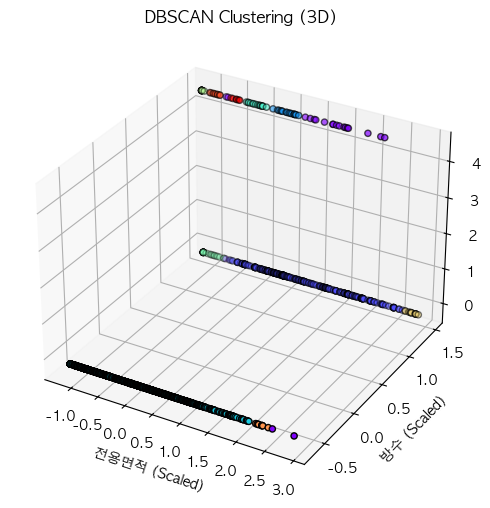

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_m_scaled[:, 0], X_m_scaled[:, 1], X_m_scaled[:, 2], c=y_dbscan, cmap='rainbow', edgecolors='black')

ax.set_title("DBSCAN Clustering (3D)")
ax.set_xlabel("전용면적 (Scaled)")
ax.set_ylabel("방수 (Scaled)")
ax.set_zlabel("욕실수 (Scaled)")

plt.show()


In [54]:
ttrain3['매물_DBSCAN'] = y_dbscan

In [55]:
ttrain3['매물_DBSCAN'].value_counts() #노이즈 ID : -1

매물_DBSCAN
 2    1129
 0     398
 4      33
-1      21
 1      17
 3      15
 5      15
 6      13
 7       9
 8       9
 9       6
Name: count, dtype: int64

노이즈 클러스터에 할당된 샘플 knn으로 재배치 

In [56]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# 노이즈(-1) 데이터 찾기
noise_mask = (y_dbscan == -1)
non_noise_mask = ~noise_mask

# 노이즈가 아닌 데이터로 KNN 학습
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_m_scaled[non_noise_mask], y_dbscan[non_noise_mask])

# 노이즈 데이터에 대해 KNN으로 클러스터 배정
y_dbscan_filled = y_dbscan.copy()
y_dbscan_filled[noise_mask] = knn.predict(X_m_scaled[noise_mask])

In [57]:
ttrain3['매물_DBSCAN'] = y_dbscan_filled
ttrain3['매물_DBSCAN']

3       0
5       0
8       1
9       0
10      2
       ..
2446    2
2447    6
2449    2
2450    0
2451    0
Name: 매물_DBSCAN, Length: 1665, dtype: int64

In [58]:
ttrain3['매물_DBSCAN'].value_counts() #노이즈 ID : -1

매물_DBSCAN
2    1129
0     398
4      34
1      33
3      15
5      15
6      13
7      11
8      10
9       7
Name: count, dtype: int64

In [59]:
ttrain3[['매물_HC', '매물_DBSCAN']]

,매물_HC,매물_DBSCAN
3,6,0
5,6,0
8,4,1
9,5,0
10,3,2
...,...,...
2446,2,2
2447,5,6
2449,2,2
2450,6,0


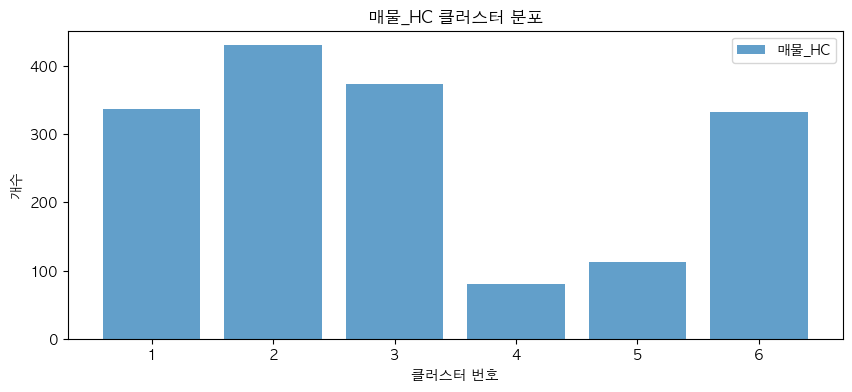

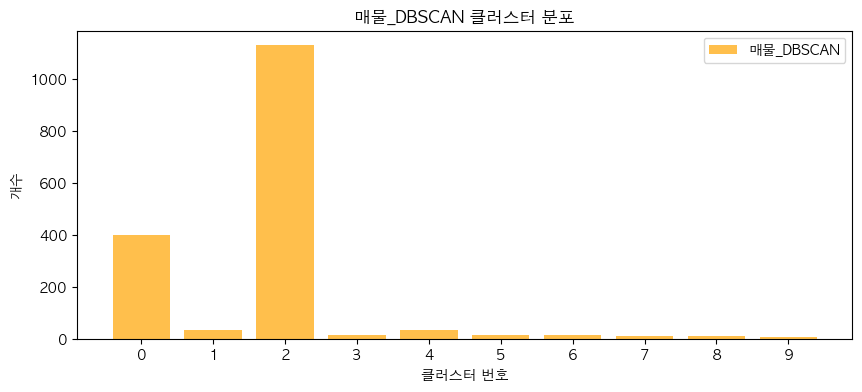

In [60]:
import matplotlib.pyplot as plt

# 매물_HC와 매물_DBSCAN의 분포 계산
hc_counts = ttrain3['매물_HC'].value_counts().sort_index()
dbscan_counts = ttrain3['매물_DBSCAN'].value_counts().sort_index()

# 그래프 그리기 - 매물_HC
plt.figure(figsize=(10, 4))
plt.bar(hc_counts.index, hc_counts.values, alpha=0.7, label='매물_HC')
plt.xlabel('클러스터 번호')
plt.ylabel('개수')
plt.title('매물_HC 클러스터 분포')
plt.xticks(hc_counts.index)
plt.legend()
plt.show()

# 그래프 그리기 - 매물_DBSCAN
plt.figure(figsize=(10, 4))
plt.bar(dbscan_counts.index, dbscan_counts.values, alpha=0.7, color='orange', label='매물_DBSCAN')
plt.xlabel('클러스터 번호')
plt.ylabel('개수')
plt.title('매물_DBSCAN 클러스터 분포')
plt.xticks(dbscan_counts.index)
plt.legend()
plt.show()


매물 클러스터링의 경우 클러스터의 크기가 너무 불균형하지 않고, 상대적으로 균등하게 분포되었기에 매물_HC변수를 사용하는 것이 좋을 듯하다.(하지만 확실히 하기 위해 모델 훈련예측 시켜보기)

(DBSCAN의 경우 이상치(노이즈)가 많은 경우 적절할 수 있다.)

### 지역 클러스터링

In [79]:
ttrain3["보증금"] = ttrain3["보증금"] / 10000
ttrain3["월세"] = ttrain3["월세"] / 10000

In [80]:
ttrain3['월세+관리비']  = ttrain3['월세'] + ttrain3['관리비']

In [81]:
ttrain3['보증금_월세관리비_비율'] =  ttrain3['월세+관리비'] / ttrain3['보증금']

In [82]:
ttrain3['보증금_월세관리비_비율'] = ttrain3['월세+관리비'] / ttrain3['보증금']
ttrain3['전용면적_가격_비율'] = ttrain3['보증금_월세관리비_비율'] / ttrain3['전용면적']
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율
3,TRAIN_0003,현장확인,16350.0,3.0,36.30,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,6,0,13.0,0.000795,0.000022
5,TRAIN_0005,전화확인,15300.0,53.0,29.50,4.0,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0,6,0,53.0,0.003464,0.000117
8,TRAIN_0008,현장확인,12050.0,44.0,31.55,1.0,2.0,북향,2.0,2.0,가능,18.0,3,G52Iz8V2B9,B플랫폼,2024-05-23,0,4,1,47.0,0.003900,0.000124
9,TRAIN_0009,현장확인,7950.0,26.0,39.66,2.0,3.0,남동향,2.0,1.0,불가능,2.0,0,M90Ph8W9V3,B플랫폼,2024-11-30,0,5,0,26.0,0.003270,0.000082
10,TRAIN_0010,현장확인,18750.0,39.0,23.69,1.0,15.0,남향,1.0,1.0,불가능,15.0,5,G52Iz8V2B9,A플랫폼,2023-12-16,0,3,2,44.0,0.002347,0.000099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,TRAIN_2446,전화확인,36550.0,19.0,17.50,4.0,14.0,남향,1.0,1.0,가능,104.0,10,G38pb6B9C7,C플랫폼,2024-12-10,0,2,2,29.0,0.000793,0.000045
2447,TRAIN_2447,서류확인,15900.0,55.0,48.95,3.0,3.0,남향,2.0,1.0,불가능,17.0,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,5,0,55.0,0.003459,0.000071
2449,TRAIN_2449,전화확인,32900.0,61.0,17.50,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,2,2,71.0,0.002158,0.000123
2450,TRAIN_2450,현장확인,3100.0,40.0,22.87,8.0,9.0,남동향,2.0,1.0,가능,17.0,8,m69GM9O9B3,B플랫폼,2024-08-06,0,6,0,48.0,0.015484,0.000677


가정 : 비슷한 매물의 경우, 주변 지역의 시세에 맞게 가격이 책정된다.

범주형인 매물 클러스터 컬럼을 포함하기 위해 K-means가 아니라 K-medoids와 HDBSCAN을 이용해보려 한다.
- K-Medoids : K-Means와 유사하지만, 중심점을 평균이 아닌 실제 데이터 중 하나로 설정한다. (이상치에 강하다)
- HDBSCAN : 밀도기반 클러스터링(DBSCAN을 개선한 것)

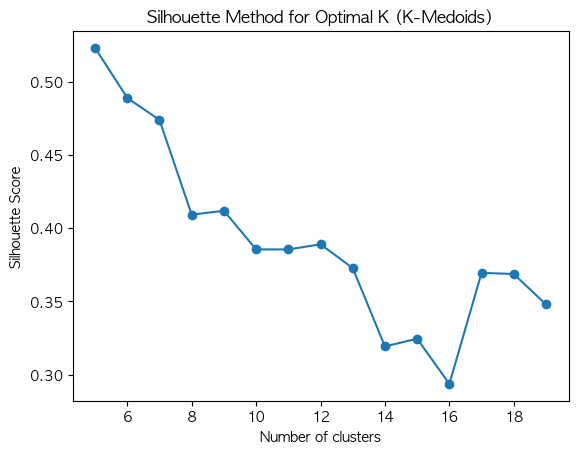

최적의 K 값: 5


In [85]:
# from sklearn_extra.cluster import KMedoids
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import silhouette_score
# import numpy as np
# import matplotlib.pyplot as plt

# # 데이터 스케일링
# X_m2 = ttrain3[['매물_HC','매물_DBSCAN', '전용면적_가격_비율', '보증금_월세관리비_비율']]
# scaler = StandardScaler()
# X_m_scaled2 = scaler.fit_transform(X_m2)

# # 최적의 K 찾기 (Silhouette Score 사용)
# silhouette_scores = []
# k_range = range(5, 20)

# for k in k_range:
#     kmedoids = KMedoids(n_clusters=k, random_state=42)
#     labels = kmedoids.fit_predict(X_m_scaled2)
#     score = silhouette_score(X_m_scaled2, labels)
#     silhouette_scores.append(score)

# # 최적 K 시각화
# plt.plot(k_range, silhouette_scores, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Method for Optimal K (K-Medoids)')
# plt.show()

# # 최적 K 값 선택
# best_k = k_range[np.argmax(silhouette_scores)]
# print(f"최적의 K 값: {best_k}")

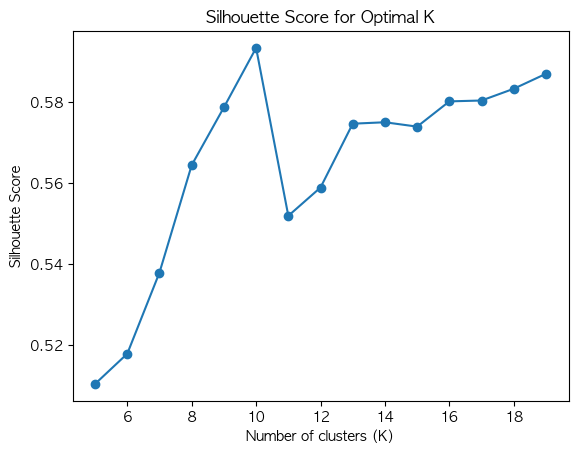

최적의 K값: 10, 최고 실루엣 계수: 0.5933


In [86]:
# # 매물 DBSCAN 포함
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 다양한 K값에 대해 실루엣 계수 계산
# silhouette_scores = []
# K_range = range(5, 20)  # K 값 범위

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(X_m_scaled2)
#     score = silhouette_score(X_m_scaled2, labels)
#     silhouette_scores.append(score)

# # 실루엣 계수 시각화
# plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score for Optimal K')
# plt.show()

# # 최적의 K값 출력
# best_k = K_range[np.argmax(silhouette_scores)]
# print(f'최적의 K값: {best_k}, 최고 실루엣 계수: {max(silhouette_scores):.4f}')

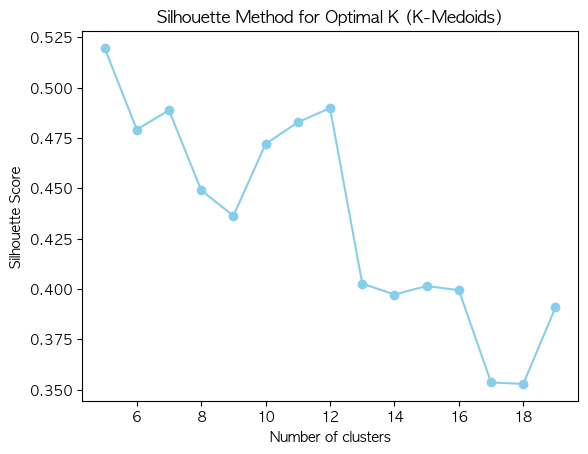

최적의 K 값: 5


In [89]:
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# 데이터 스케일링
X_m2 = ttrain3[['매물_HC', '전용면적_가격_비율', '보증금_월세관리비_비율']]
scaler = StandardScaler()
X_m_scaled2 = scaler.fit_transform(X_m2)

# 최적의 K 찾기 (Silhouette Score 사용)
silhouette_scores = []
k_range = range(5, 20)

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    labels = kmedoids.fit_predict(X_m_scaled2)
    score = silhouette_score(X_m_scaled2, labels)
    silhouette_scores.append(score)

# 최적 K 시각화
plt.plot(k_range, silhouette_scores, marker='o', color = 'skyblue')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K (K-Medoids)')
plt.show()

# 최적 K 값 선택
best_k = k_range[np.argmax(silhouette_scores)]
print(f"최적의 K 값: {best_k}")

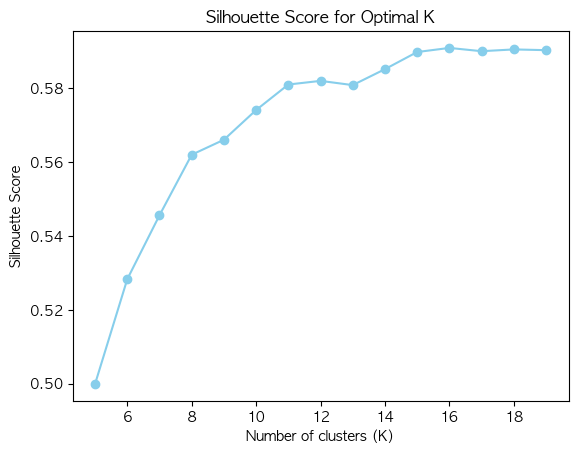

최적의 K값: 16, 최고 실루엣 계수: 0.5909


In [88]:
# 매물 DBSCAN 포함 x
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 다양한 K값에 대해 실루엣 계수 계산
silhouette_scores = []
K_range = range(5, 20)  # K 값 범위

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_m_scaled2)
    score = silhouette_score(X_m_scaled2, labels)
    silhouette_scores.append(score)

# 실루엣 계수 시각화
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color = 'skyblue')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

# 최적의 K값 출력
best_k = K_range[np.argmax(silhouette_scores)]
print(f'최적의 K값: {best_k}, 최고 실루엣 계수: {max(silhouette_scores):.4f}')


최적의 k값은 12라고 생각되지만, 클러스터링 패턴이 확 바뀌지 않는, 좀 더 안정적인 k값을 위해 11 선택.

In [90]:
# K-Medoids
kmedoids = KMedoids(n_clusters=11, random_state=42)
ttrain3['지역_KMedoids'] = kmedoids.fit_predict(X_m_scaled2)

In [91]:
ttrain3['지역_KMedoids'].value_counts()

지역_KMedoids
9     366
8     305
4     266
2     126
5     111
6     105
10    102
0      91
3      69
7      62
1      62
Name: count, dtype: int64

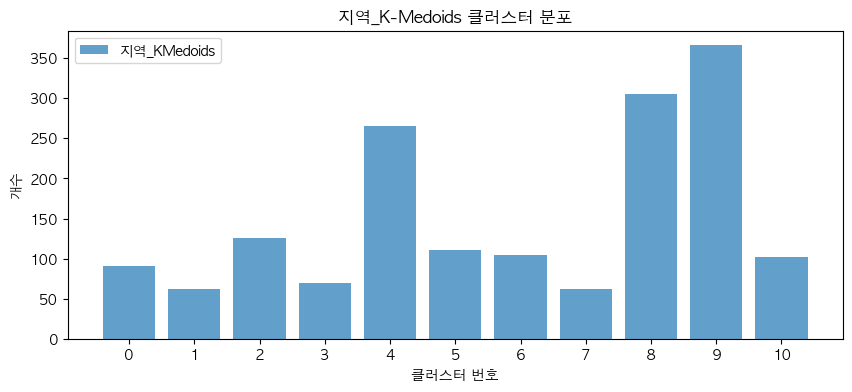

In [92]:
import matplotlib.pyplot as plt

# 지역_kmedoids의 분포 계산
kmedoids_counts = ttrain3['지역_KMedoids'].value_counts().sort_index()

# 그래프 그리기 - 지역 kmedoids
plt.figure(figsize=(10, 4))
plt.bar(kmedoids_counts.index, kmedoids_counts.values, alpha=0.7, label='지역_KMedoids')
plt.xlabel('클러스터 번호')
plt.ylabel('개수')
plt.title('지역_K-Medoids 클러스터 분포')
plt.xticks(kmedoids_counts.index)
plt.legend()
plt.show()

In [110]:
# import hdbscan

# HDBSCAN 클러스터링 수행
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon = 0.05)
y_hdbscan = hdb.fit_predict(X_m_scaled2)
ttrain3['지역_HDBSCAN'] = y_hdbscan

# 클러스터 개수 확인
ttrain3['지역_HDBSCAN'].value_counts()


지역_HDBSCAN
 8     363
 10    290
 4     280
 6     277
-1     200
 0     107
 1      70
 7      19
 3      17
 2      17
 5      15
 9      10
Name: count, dtype: int64

In [111]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# 노이즈(-1) 데이터 찾기
noise_mask = (y_hdbscan == -1)
non_noise_mask = ~noise_mask

# 노이즈가 아닌 데이터로 KNN 학습
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_m_scaled2[non_noise_mask], y_hdbscan[non_noise_mask])

# 노이즈 데이터에 대해 KNN으로 클러스터 배정
y_hdbscan_filled = y_hdbscan.copy()
y_hdbscan_filled[noise_mask] = knn.predict(X_m_scaled2[noise_mask])

In [112]:
ttrain3['지역_HDBSCAN'] = y_hdbscan_filled
ttrain3['지역_HDBSCAN']

3        4
5        4
8        1
9        0
10      10
        ..
2446     8
2447     0
2449     8
2450     3
2451     4
Name: 지역_HDBSCAN, Length: 1665, dtype: int64

In [113]:
ttrain3['지역_HDBSCAN'].value_counts() #노이즈 ID : -1

지역_HDBSCAN
8     370
10    291
4     280
6     277
0     110
7     110
1      76
2      68
5      33
9      31
3      19
Name: count, dtype: int64

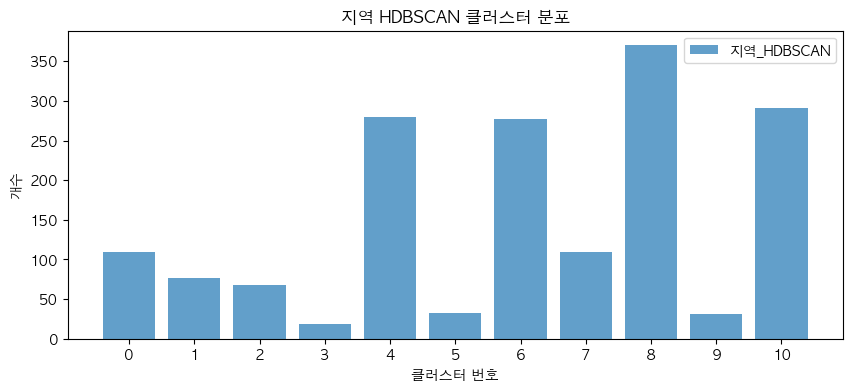

In [114]:
import matplotlib.pyplot as plt

# 지역_kmedoids의 분포 계산
hdbscan_counts = ttrain3['지역_HDBSCAN'].value_counts().sort_index()

# 그래프 그리기 - 지역 HDBSCAN
plt.figure(figsize=(10, 4))
plt.bar(hdbscan_counts.index, hdbscan_counts.values, alpha=0.7, label='지역_HDBSCAN')
plt.xlabel('클러스터 번호')
plt.ylabel('개수')
plt.title('지역 HDBSCAN 클러스터 분포')
plt.xticks(kmedoids_counts.index)
plt.legend()
plt.show()

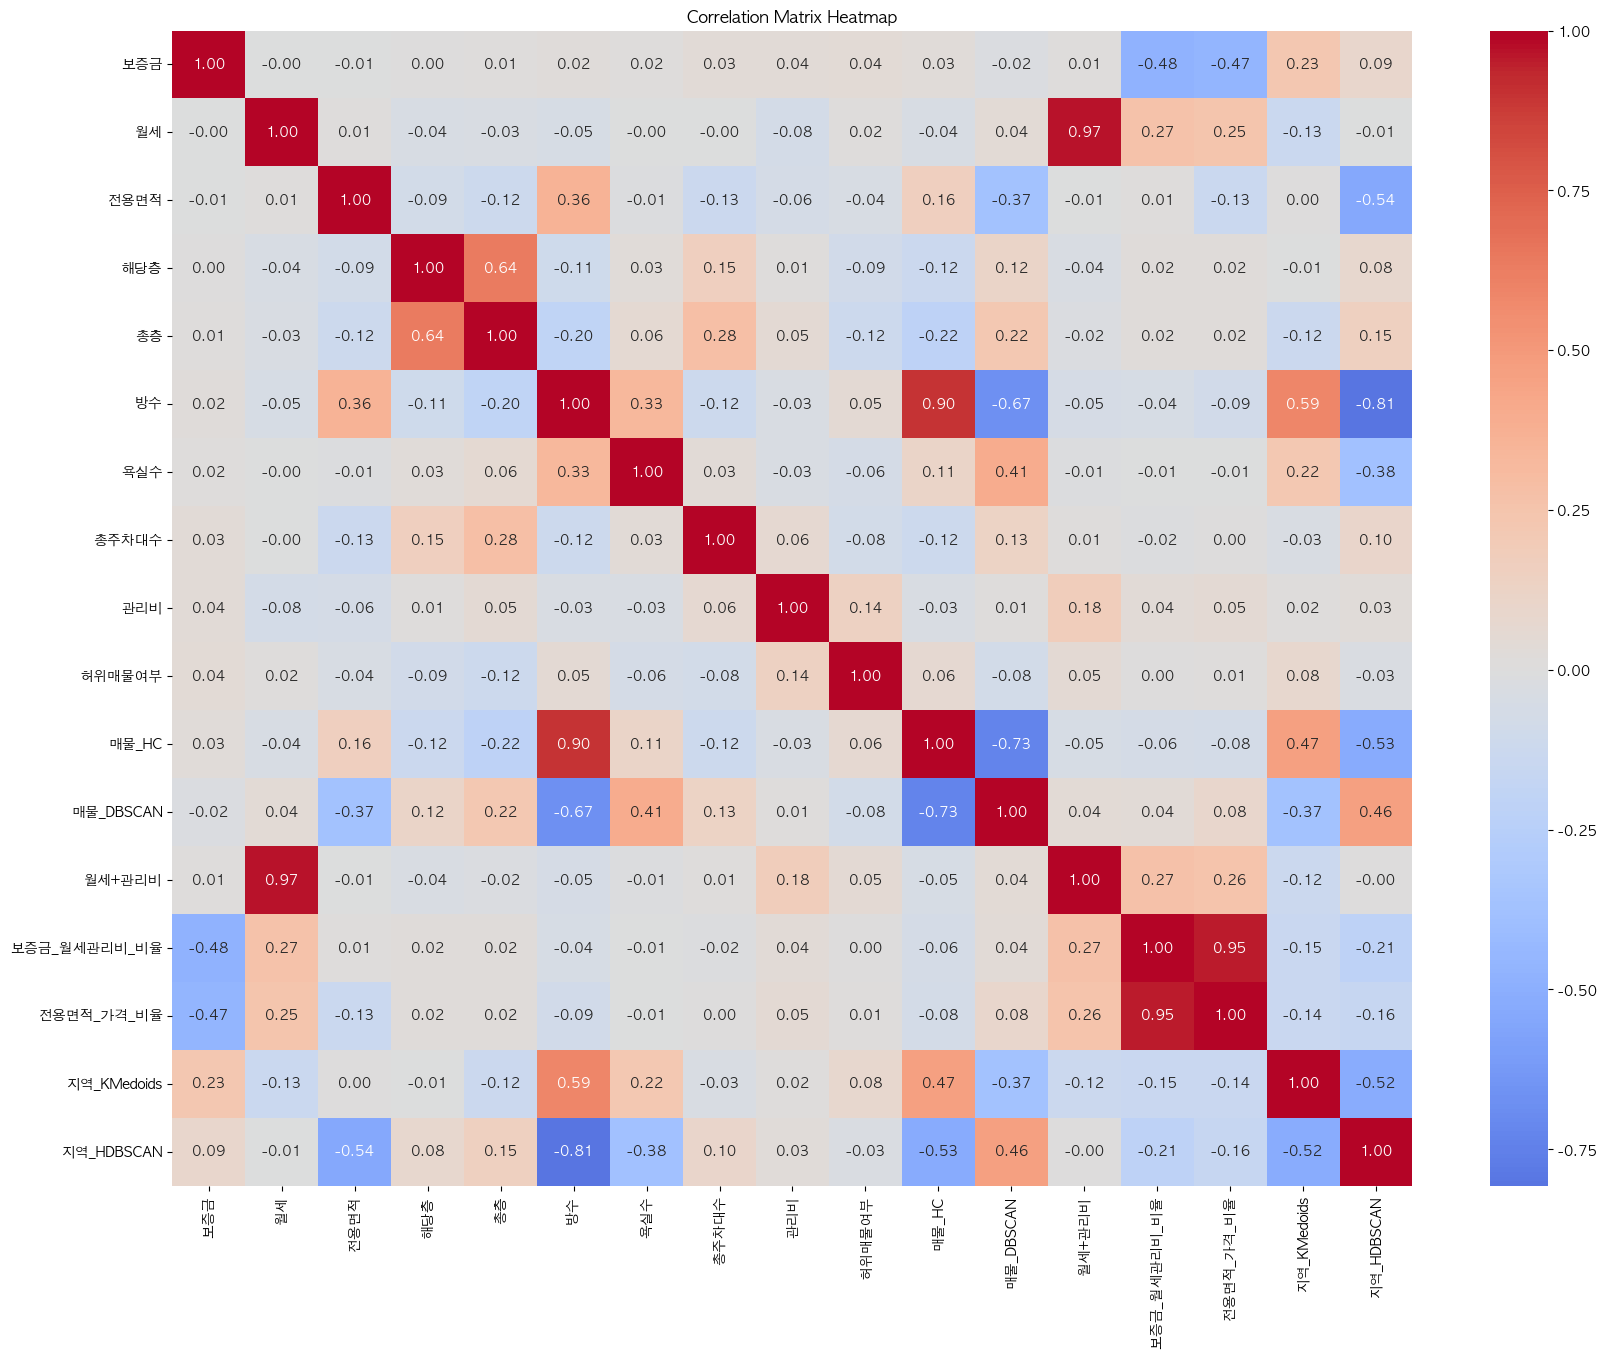

In [115]:
ttrain_cor_df = ttrain3.select_dtypes(include=[np.number])
correlation_matrix = ttrain_cor_df.corr()

# 히트맵 생성
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, center = 0)
plt.title("Correlation Matrix Heatmap")
plt.savefig("./image/feature_transformation/correlation_matrix_heatmap_pearson_250208.png", dpi=300, bbox_inches='tight')
plt.show()

모드 변수들이 허위매물 여부를 강하게 설명하지 못하고 있어, 단순한 선형 상관관계로 허위매물을 판별하기 어렵습니다. 따라서 Feature Transformation을 통해 의미 있는 컬럼을 만들어야 합니다.

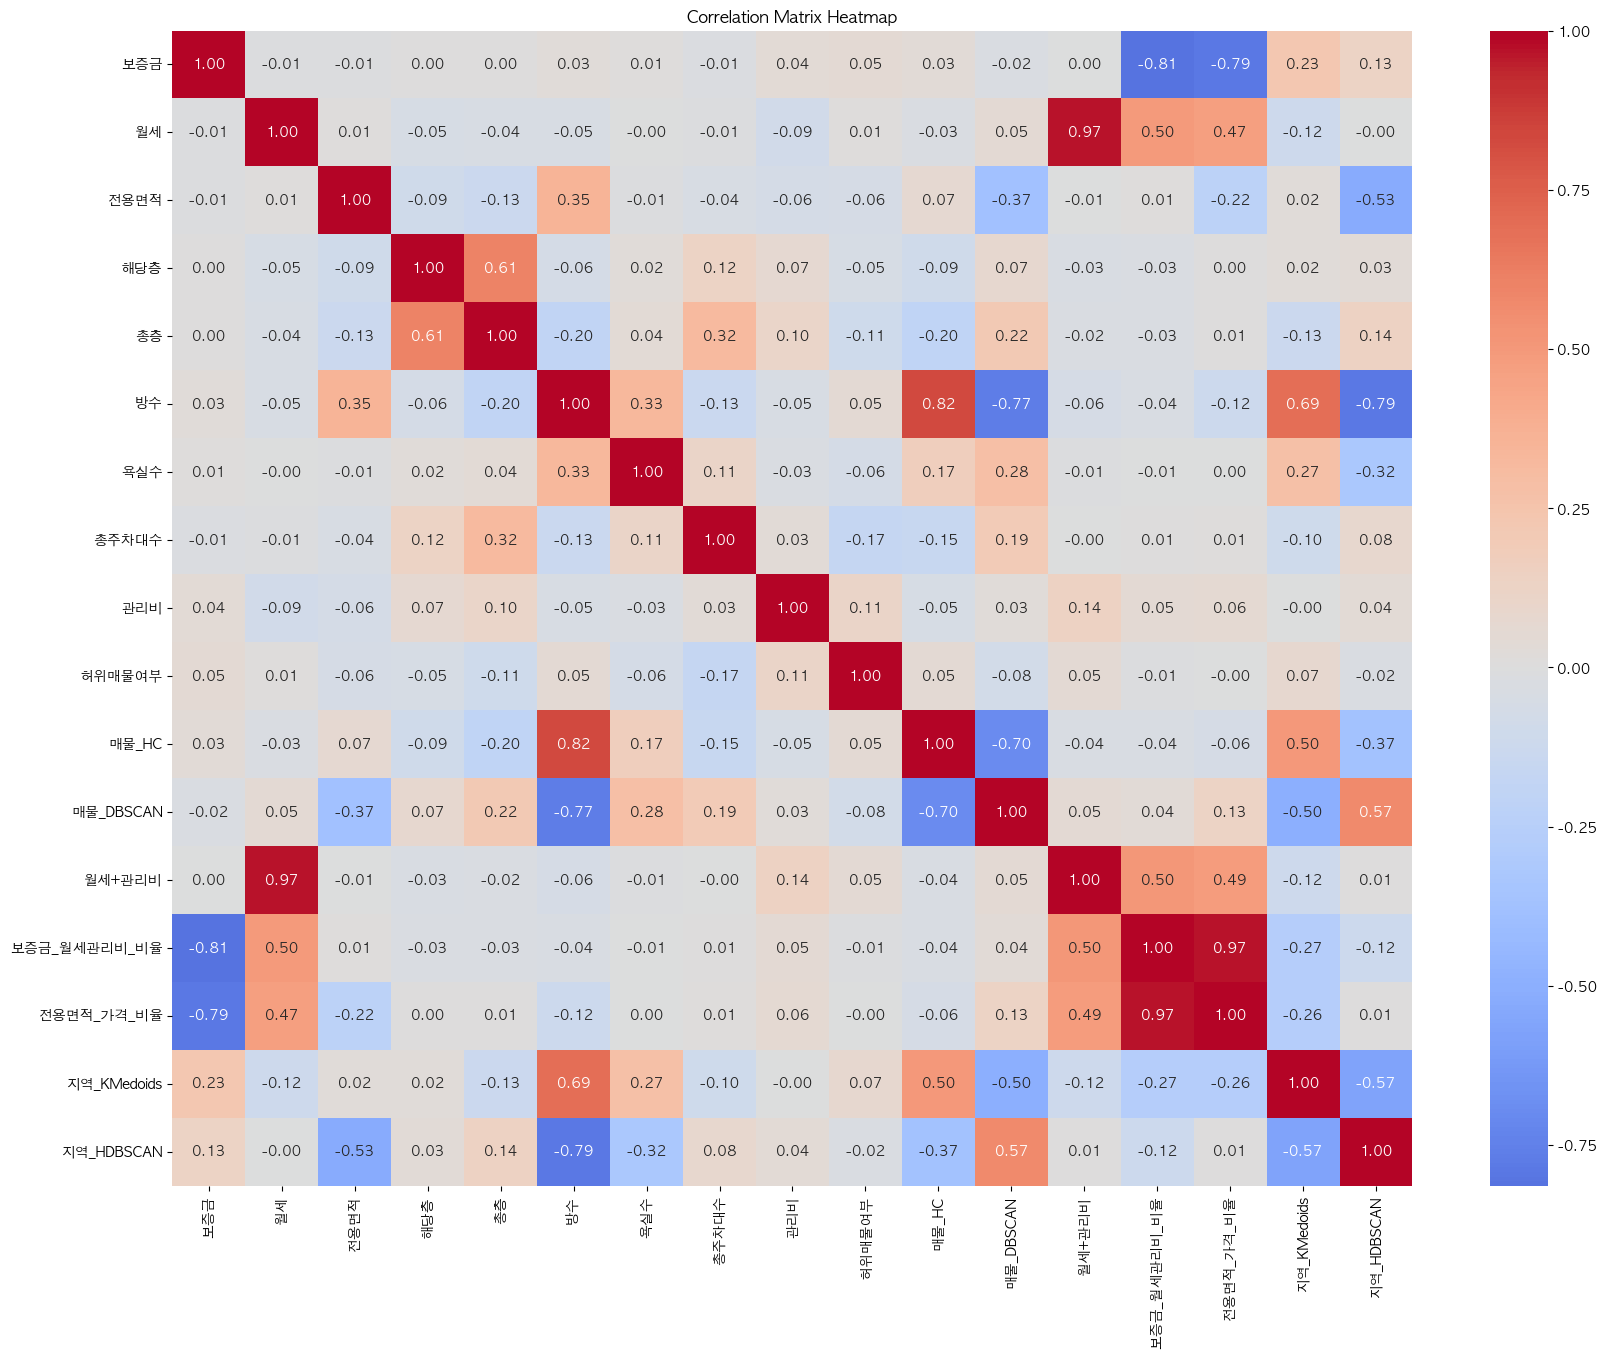

In [116]:
ttrain_cor_df = ttrain3.select_dtypes(include=[np.number])
correlation_matrix = ttrain_cor_df.corr(method='spearman')

# 히트맵 생성
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, center = 0)
plt.title("Correlation Matrix Heatmap")
plt.savefig("./image/feature_transformation/correlation_matrix_heatmap_spearman_250208.png", dpi=300, bbox_inches='tight')
plt.show()

In [453]:
import sys
!{sys.executable} -m pip install scikit-learn-extra

  Using cached scikit-learn-extra-0.3.0.tar.gz (818 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-macosx_11_0_arm64.whl size=399986 sha256=761a7f51fb275391f8bd6369a84e2ae627f4a4e3c134393be716a57a6bf34509
  Stored in directory: /Users/kimminyoung/Library/Caches/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


### 계절 변수 생성

In [584]:
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

ttrain3['게재일'] = pd.to_datetime(ttrain3['게재일'], errors='coerce')
ttrain3['계절'] = ttrain3['게재일'].dt.month.apply(get_season)
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율,지역_KMedoids,지역_HDBSCAN,계절
3,TRAIN_0003,현장확인,16350.0,3.0,36.30,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,6,0,13.0,0.000795,0.000022,4,8,가을
5,TRAIN_0005,전화확인,15300.0,53.0,29.50,4.0,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0,6,0,53.0,0.003464,0.000117,4,8,가을
8,TRAIN_0008,현장확인,12050.0,44.0,31.55,1.0,2.0,북향,2.0,2.0,가능,18.0,3,G52Iz8V2B9,B플랫폼,2024-05-23,0,4,1,47.0,0.003900,0.000124,1,2,봄
9,TRAIN_0009,현장확인,7950.0,26.0,39.66,2.0,3.0,남동향,2.0,1.0,불가능,2.0,0,M90Ph8W9V3,B플랫폼,2024-11-30,0,5,0,26.0,0.003270,0.000082,4,3,가을
10,TRAIN_0010,현장확인,18750.0,39.0,23.69,1.0,15.0,남향,1.0,1.0,불가능,15.0,5,G52Iz8V2B9,A플랫폼,2023-12-16,0,3,2,44.0,0.002347,0.000099,2,5,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,TRAIN_2446,전화확인,36550.0,19.0,17.50,4.0,14.0,남향,1.0,1.0,가능,104.0,10,G38pb6B9C7,C플랫폼,2024-12-10,0,2,2,29.0,0.000793,0.000045,5,6,겨울
2447,TRAIN_2447,서류확인,15900.0,55.0,48.95,3.0,3.0,남향,2.0,1.0,불가능,17.0,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,5,0,55.0,0.003459,0.000071,4,3,가을
2449,TRAIN_2449,전화확인,32900.0,61.0,17.50,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,2,2,71.0,0.002158,0.000123,5,6,봄
2450,TRAIN_2450,현장확인,3100.0,40.0,22.87,8.0,9.0,남동향,2.0,1.0,가능,17.0,8,m69GM9O9B3,B플랫폼,2024-08-06,0,6,0,48.0,0.015484,0.000677,6,7,여름


In [587]:
ttrain3['매물_등록_경과일'] = (ttrain3['게재일'].max() - ttrain3['게재일']).dt.days

<Figure size 10000x2500 with 0 Axes>

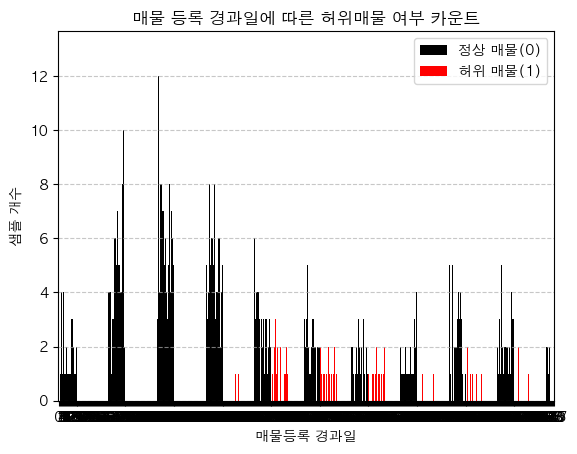

In [596]:
import matplotlib.pyplot as plt
import pandas as pd

# 월별 허위매물 여부(0, 1) 카운트
count_df = ttrain3.groupby(['매물_등록_경과일', '허위매물여부']).size().unstack(fill_value=0)

# 바 차트 그리기
plt.figure(figsize=(100, 25))
count_df.plot(kind='bar', stacked=False, width=0.7, color=['black', 'red'])

# 그래프 스타일 설정
plt.xlabel('매물등록 경과일')
plt.ylabel('샘플 개수')
plt.title('매물 등록 경과일에 따른 허위매물 여부 카운트')
plt.legend(['정상 매물(0)', '허위 매물(1)'])
plt.xticks(rotation=0)  # X축 라벨 가독성 조정
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.show()

In [602]:
ttrain3[(ttrain3.매물_등록_경과일<150)&(ttrain3.허위매물여부==1)]

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율,지역_KMedoids,지역_HDBSCAN,계절,매물_등록_경과일
230,TRAIN_0230,현장확인,9500.0,65.0,17.5,3.0,6.0,남향,1.0,1.0,불가능,3.0,13,I97SP1K4K9,A플랫폼,2024-10-08,1,2,2,78.0,0.008211,0.000469,3,6,가을,146
2186,TRAIN_2186,현장확인,9300.0,55.0,17.5,4.0,5.0,남향,1.0,1.0,불가능,17.0,11,Q65VU2R1S3,A플랫폼,2024-10-08,1,2,2,66.0,0.007097,0.000406,3,6,가을,146


In [603]:
ttrain3.columns

Index(['ID', '매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수',
       '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물여부', '매물_HC',
       '매물_DBSCAN', '월세+관리비', '보증금_월세관리비_비율', '전용면적_가격_비율', '지역_KMedoids',
       '지역_HDBSCAN', '계절', '매물_등록_경과일'],
      dtype='object')

### 필요 없는 컬럼 제거

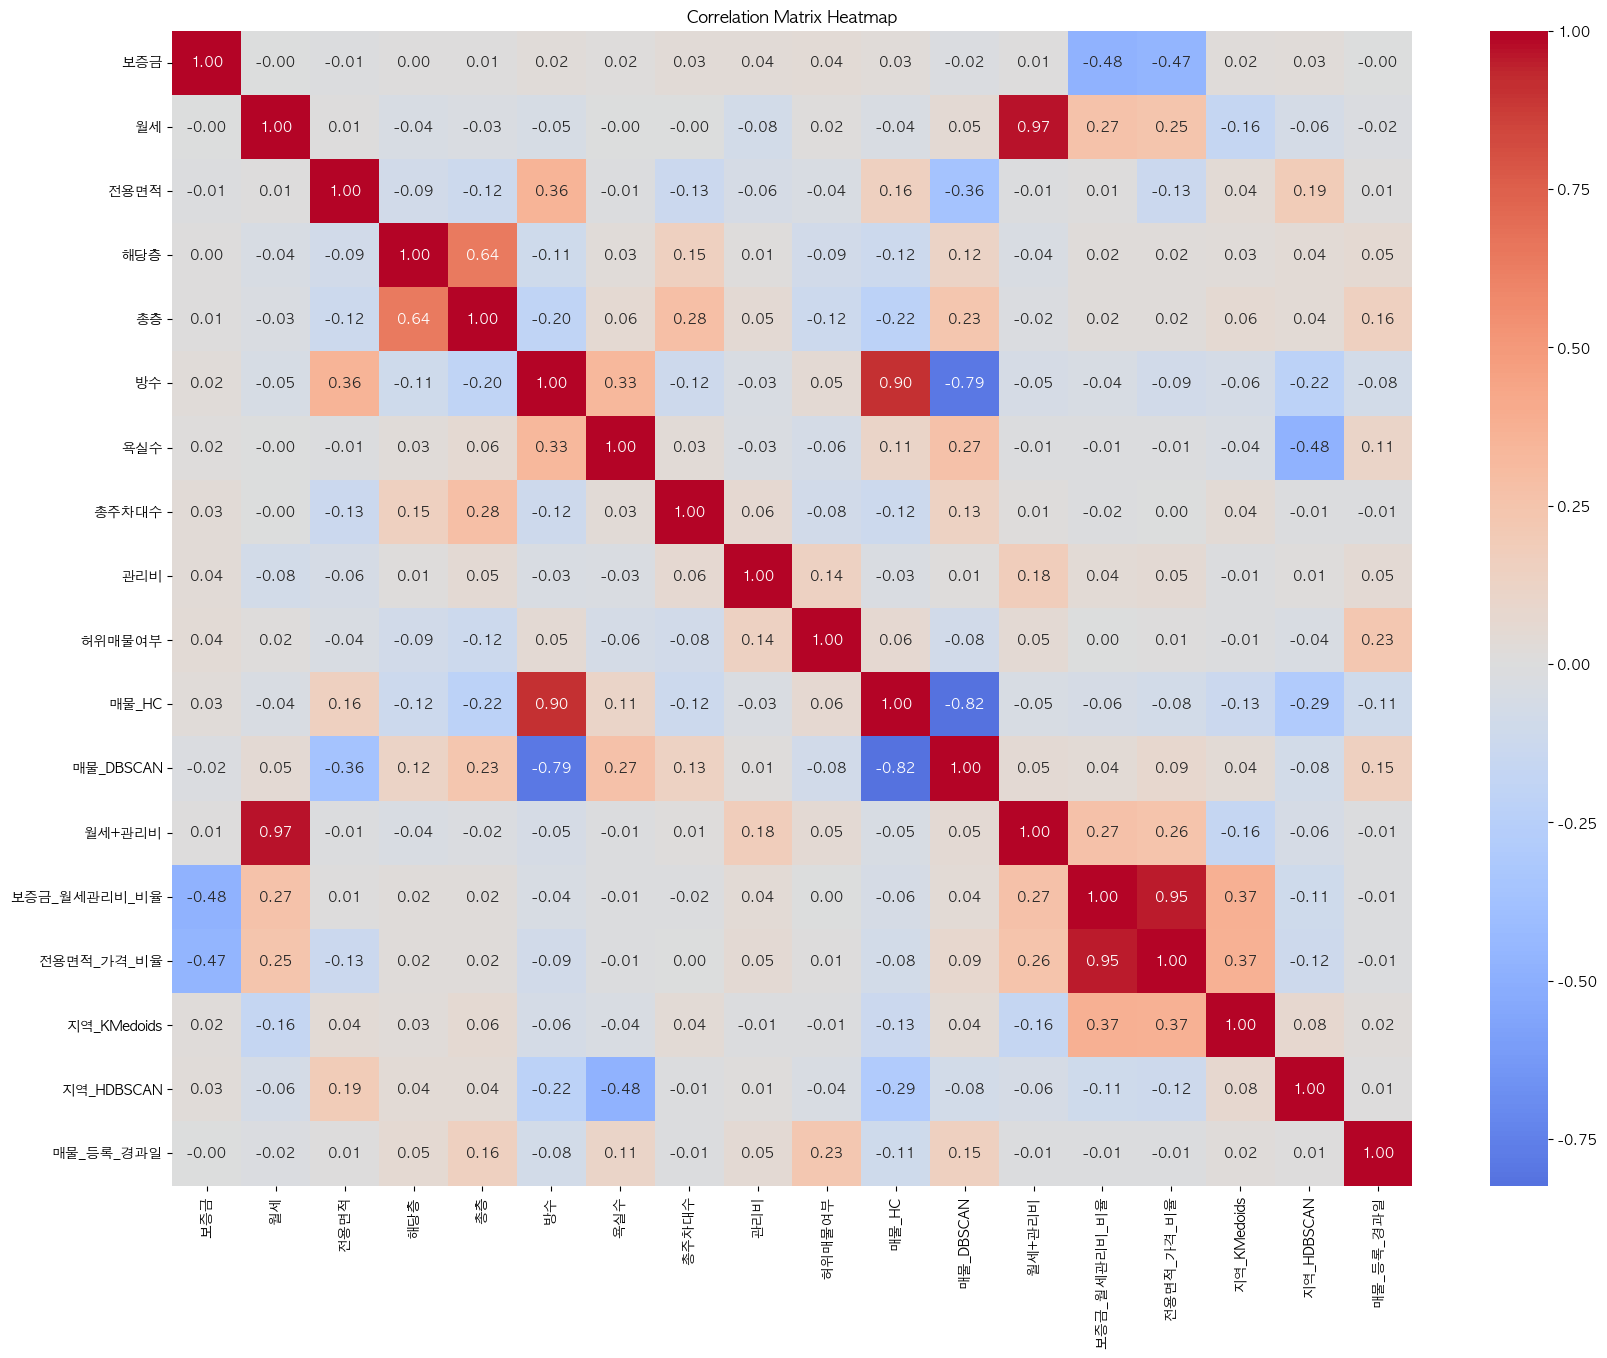

In [613]:
ttrain_cor_df = ttrain3.select_dtypes(include=[np.number])
correlation_matrix = ttrain_cor_df.corr()

# 히트맵 생성
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, center = 0)
plt.title("Correlation Matrix Heatmap")
plt.savefig("./image/feature_transformation/correlation_matrix_heatmap_pearson_250205.png", dpi=300, bbox_inches='tight')
plt.show()

모드 변수들이 허위매물 여부를 강하게 설명하지 못하고 있어, 단순한 선형 상관관계로 허위매물을 판별하기 어렵습니다. 따라서 Feature Transformation을 통해 의미 있는 컬럼을 만들어야 합니다.

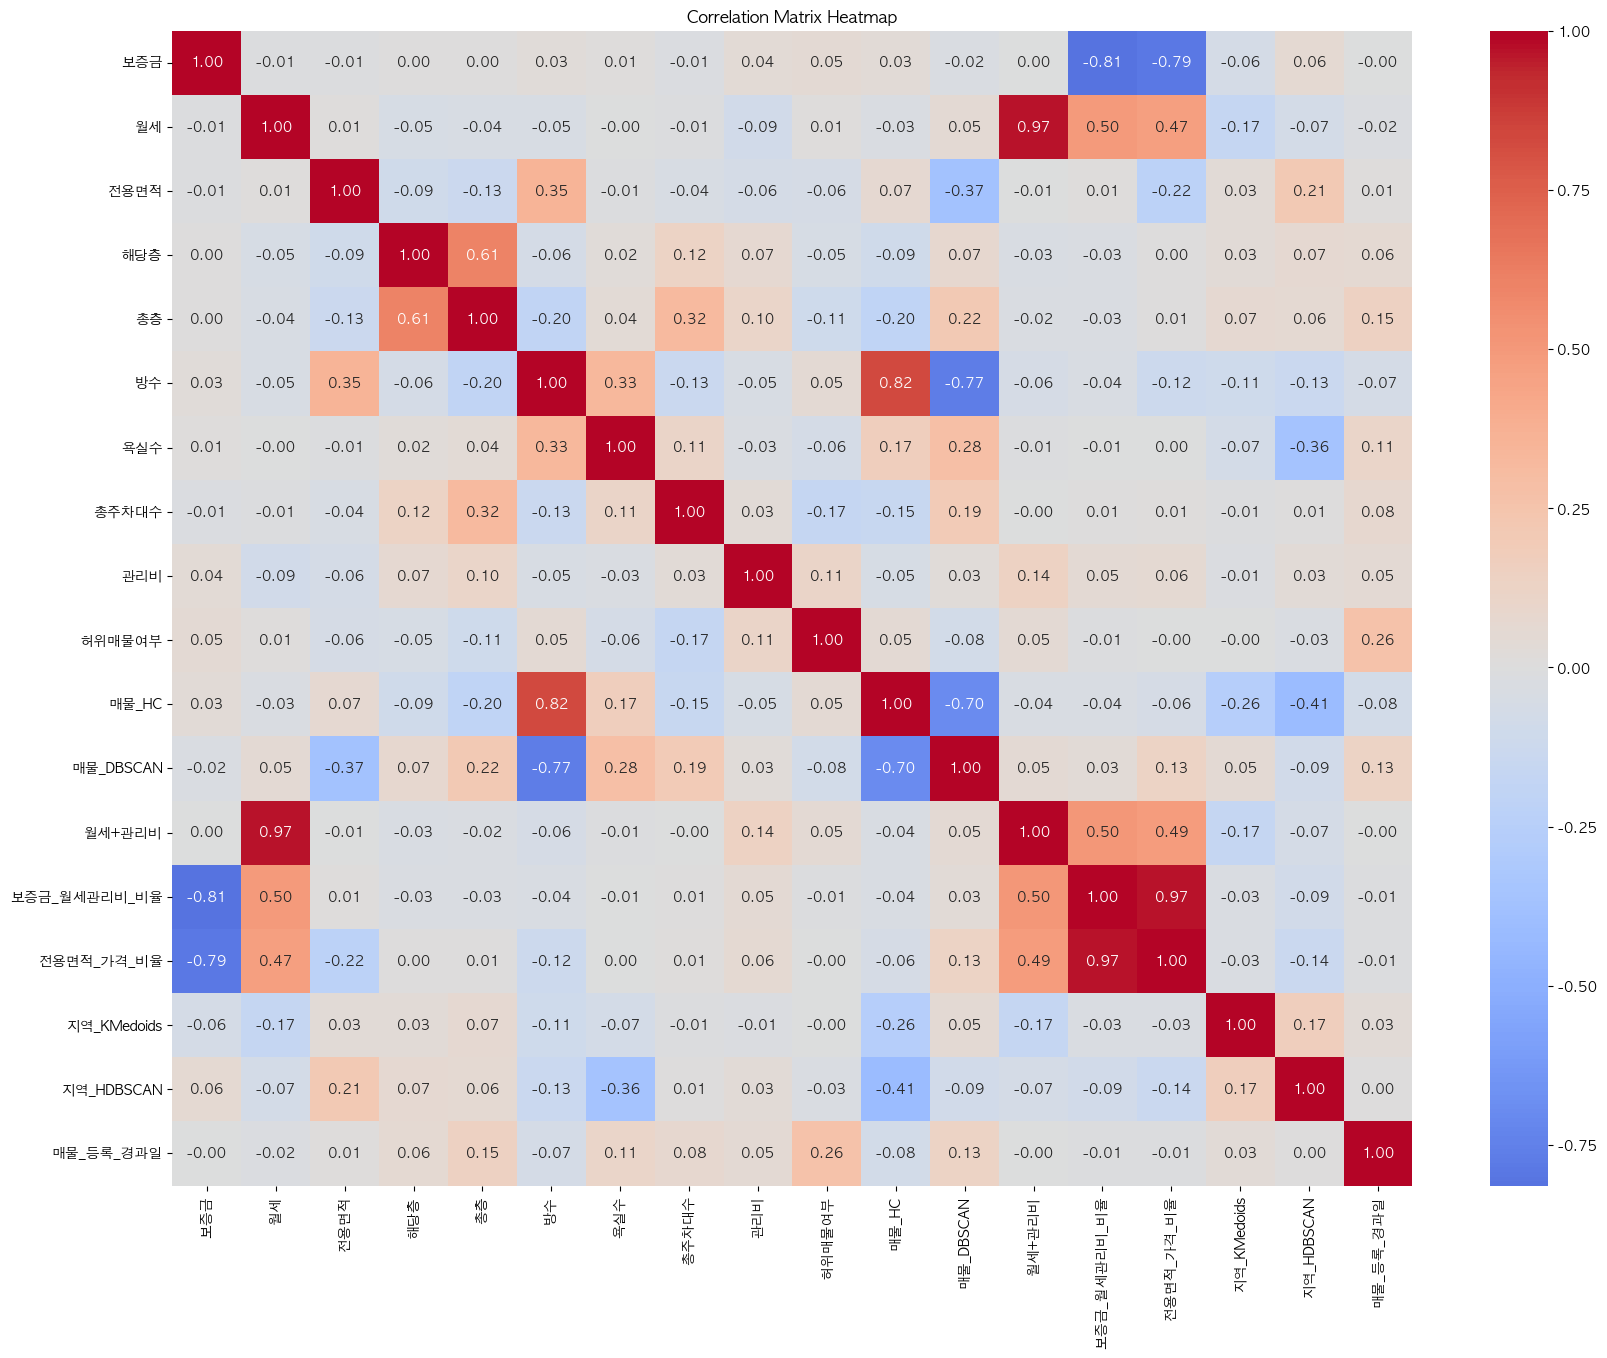

In [614]:
ttrain_cor_df = ttrain3.select_dtypes(include=[np.number])
correlation_matrix = ttrain_cor_df.corr(method='spearman')

# 히트맵 생성
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, center = 0)
plt.title("Correlation Matrix Heatmap")
plt.savefig("./image/feature_transformation/correlation_matrix_heatmap_spearman_250205.png", dpi=300, bbox_inches='tight')
plt.show()

- ID 제거
- 중개사무소, 제공 플랫폼 등 허위매물여부와 관련성 없고, 고유한 값이 많은 컬럼 제거
- 게재일 : 계절이나 매물등록경과일 등 필요에 맞게 전처리한 컬럼 제거
- 월세, 보증금의 경우 모델을 돌려보면서 제거할지 포함할지 정하기
- 보증금_월세관리비_비율 : 전용면적_가격_비율과 상관관계가 높기 때문에 제거(0.97)

In [615]:
ttrain3 = ttrain3.drop(columns = ['ID', '중개사무소', '제공플랫폼', '게재일', '보증금_월세관리비_비율'])
ttrain3.columns

Index(['매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수', '주차가능여부',
       '총주차대수', '관리비', '허위매물여부', '매물_HC', '매물_DBSCAN', '월세+관리비', '전용면적_가격_비율',
       '지역_KMedoids', '지역_HDBSCAN', '계절', '매물_등록_경과일'],
      dtype='object')

In [616]:
ttrain3.to_csv('./data/ttrain3.csv', index = False)

## 범주형 데이터 원 핫 인코딩

In [ ]:
ttrain3 = pd.get_dummies(ttrain3, columns=['매물확인방식', '방향', '주차가능여부'], drop_first=True)